In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Relative location of drive to DIP project folder
drive_loc='/content/gdrive/My Drive/DIP/'

In [0]:
import numpy as np
import cv2
import keras
import random as rand
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Sequential
from keras.models import Model,load_model
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [0]:
# Load MNIST dataset
(x_train,y_train), (x_test,y_test) = mnist.load_data()

In [0]:
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
model = load_model(drive_loc + 'model.h5')

In [0]:
encoder_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)

In [0]:
# Compute features for training dataset
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
learned_codes = encoder_model.predict(x_train)
# Reshaping to convert encoded rep of shape: (number_of_images,4,4,8) to (number_of_images,4*4*8)
learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

# Compute features for query/test images
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
test_codes = encoder_model.predict(x_test)
# Reshaping to convert encoded rep of shape: (number_of_images,4,4,8) to (number_of_images,4*4*8)
test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
print(learned_codes)

In [0]:
def compute_score(test_codes, test_labels, learned_codes, y_train, n_samples):
    ans = 0
    #For each query image feature we compute the closest images from training dataset
    for i in range(len(test_codes)):
        distances = []
        # Compute the euclidian distance for each feature from training dataset
        for j in range(len(learned_codes)):
            distance = np.linalg.norm(learned_codes[j] - test_codes[i])
            distances.append((distance,y_train[j]))
        D = sorted(distances)
        D = D[:n_samples]
        count = 0
        for j in range(len(D)):
          if D[j][1] == test_labels[i]:
            count += 1
        ans += count/len(D)
    return ans/len(test_codes)    

In [12]:
n_test_samples = 500

n_train_samples = [10,20,50,100,200,300,500,1000,2000,3000,5000]

Scores = []

for n_train_sample in n_train_samples:
  print(n_train_sample)
  # We keep only n_test_samples query images from test dataset
  indexes = np.arange(len(y_test))
  np.random.shuffle(indexes)
  indexes = indexes[:n_test_samples]
  score = compute_score(test_codes[indexes], y_test[indexes], learned_codes, y_train, n_train_sample)
  Scores.append(score)

10
20
50
100
200
300
500
1000
2000
3000
5000


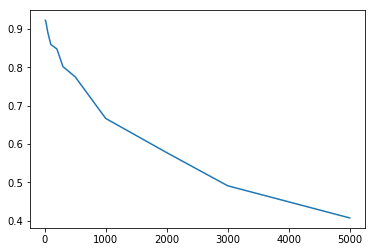

In [13]:
plt.plot(n_train_samples,Scores)
plt.show()

In [14]:
n_train_samples

[10, 20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000]

In [15]:
Scores

[0.9223999999999996,
 0.918599999999999,
 0.89148,
 0.8592400000000004,
 0.8475200000000015,
 0.8014066666666675,
 0.7748200000000002,
 0.666306,
 0.5771590000000004,
 0.49068066666666676,
 0.4068064000000002]

In [0]:
n_train_samples = [10, 20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000]
Scores = [0.8685999999999999,
 0.8546999999999992,
 0.8033999999999996,
 0.7964999999999999,
 0.7372399999999997,
 0.7196066666666674,
 0.6592359999999988,
 0.5970340000000004,
 0.4887179999999997,
 0.44847133333333344,
 0.349678]

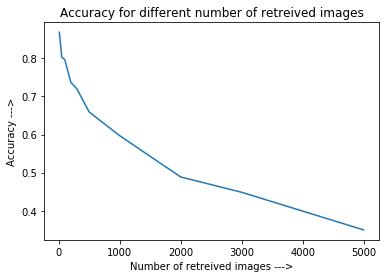

In [17]:
plt.plot(n_train_samples,Scores)
plt.title('Accuracy for different number of retreived images')
plt.xlabel('Number of retreived images --->')
plt.ylabel('Accuracy --->')
plt.show()